In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", font_scale=2.0)
import torch

from botorch.models import SingleTaskGP
from gpytorch.kernels import RQKernel, RBFKernel

In [122]:
N = 60
nv = 50
# full_x = torch.cat((torch.linspace(-3, 5, N - nv), torch.linspace(-10, 10, nv))).view(-1,1)
# full_x = torch.linspace(-3, 5, N).view(-1,1)
full_x = 3. * torch.randn(N, 1)
m2 = SingleTaskGP(full_x, torch.randn(N, 1), covar_module=RQKernel(alpha = 0.5))

In [123]:
full_x.shape

torch.Size([60, 1])

In [124]:
from gpytorch.distributions import MultivariateNormal

covar = (full_x.unsqueeze(-3) - full_x.unsqueeze(-2)).abs().mul(-2).exp().squeeze()
dist = MultivariateNormal(torch.zeros(60), covar)

In [125]:
full_y = dist.sample()

In [126]:
# indices = torch.randperm(N)
# train_x = full_x[indices[:N]]
# train_y = full_y[indices[:N]]

# calib_x = full_x[indices[N-nv:]]
# calib_y = full_y[indices[N-nv:]]
train_x = full_x[:(N - nv)]
train_y = full_y[:(N - nv)]

calib_x = full_x[(N - nv):]
calib_y = full_y[(N - nv):]

In [127]:
m2.set_train_data(train_x, train_y.squeeze(), strict=False)

In [128]:
m1 = SingleTaskGP(train_x, train_y.view(-1,1), covar_module=RBFKernel())

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch import fit_gpytorch_model
mll = ExactMarginalLogLikelihood(m1.likelihood, m1)
fit_gpytorch_model(mll);

In [129]:
m3 = SingleTaskGP(train_x, train_y.view(-1,1), covar_module=RQKernel(alpha = 0.5))
m3.likelihood.noise = 0.2

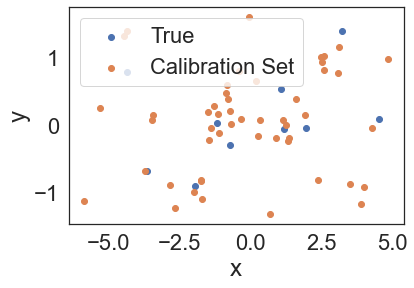

In [130]:
plt.scatter(train_x, train_y, label = "True")
plt.scatter(calib_x, calib_y, label = "Calibration Set")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

In [131]:
from botorch.acquisition import ExpectedImprovement

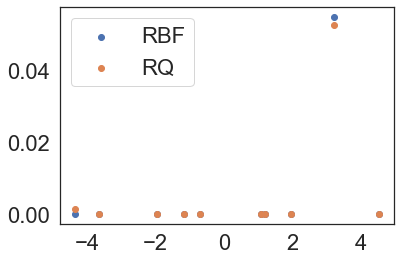

In [132]:
plt.scatter(train_x, ExpectedImprovement(m1, train_y.max())(train_x.unsqueeze(-2)).detach(), label = "RBF")
plt.scatter(train_x, ExpectedImprovement(m3, train_y.max())(train_x.unsqueeze(-2)).detach(), label = "RQ")
plt.legend()


In [133]:
def get_scores(m):
    m_post = m.posterior(calib_x)
    return torch.abs(m_post.mean.squeeze() - calib_y.squeeze()) / m_post.variance.pow(0.5).squeeze()

In [134]:
get_scores(m1)

tensor([4.0103e-01, 1.0899e+00, 5.5012e-01, 2.7788e+00, 1.1311e+00, 6.4801e-02,
        1.3060e+00, 4.9253e-01, 6.1957e-01, 4.8845e-01, 2.0432e+00, 4.0207e-01,
        4.5835e-01, 9.3104e-01, 1.2942e+00, 9.8007e-01, 1.6080e-01, 6.9934e-01,
        3.9370e-01, 1.3058e+00, 1.5330e+00, 1.2492e+00, 8.5022e-01, 1.9233e-01,
        8.6408e-01, 1.5999e+00, 5.8451e-01, 2.3839e-01, 5.0503e-01, 1.8164e-01,
        1.5333e+00, 1.1960e+00, 1.7357e-01, 9.9510e-01, 8.8049e-01, 2.0062e-01,
        9.4388e-01, 1.3893e-03, 7.3424e-01, 6.9668e-02, 1.1635e+00, 2.7706e-01,
        1.0700e+00, 7.3729e-01, 9.1270e-01, 9.5763e-01, 8.8770e-01, 1.0882e-01,
        1.3202e-01, 5.2376e-01], grad_fn=<DivBackward0>)

In [135]:
test_x = torch.linspace(-10, 10, 1000).view(-1,1).unsqueeze(-2)

In [136]:
batch_ei = (m1.posterior(test_x, observation_noise = True).sample(torch.Size((4096,))) - train_y.max().unsqueeze(-1)).clamp_min(0.).max(dim=-1)[0].mean(dim=0)

In [137]:
batch_ei_rq = (m3.posterior(test_x).sample(torch.Size((4096,))) - \
               train_y.max().unsqueeze(-1)).clamp_min(0.).max(dim=-1)[0].mean(dim=0)

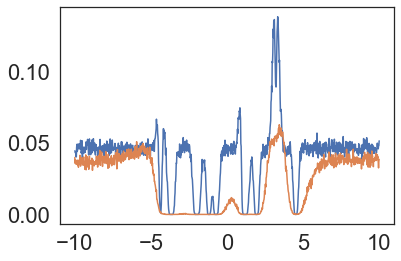

In [138]:
plt.plot(test_x.squeeze(), batch_ei.squeeze())
plt.plot(test_x.squeeze(), batch_ei_rq.squeeze())

In [139]:
%pdb

Automatic pdb calling has been turned OFF


In [140]:
def conformal_ei(m, samples = 4096, alpha = 0.05):
    scores = get_scores(m)
    # calibration set is of size 50
    # qhats = torch.quantile(scores, torch.ceil(51 * (1 - alphas)).squeeze() / 50)
    # qhat = torch.quantile(scores, (torch.ceil(51 * torch.rand(samples)) / 50).clamp(min=0, max=1.))
    qhat = torch.quantile(scores, torch.ceil((nv + 1) * (1 - alpha) * torch.ones(1)) / nv)
    
    m_post = m.posterior(test_x, observation_noise = True)
    scaling = m_post.variance.squeeze(-1).unsqueeze(0) * qhat.unsqueeze(-1).unsqueeze(-1)
    conformal_samples = torch.rand(samples, *scaling.shape[1:]) * 2 * scaling + m_post.mean.squeeze(-1).unsqueeze(0) - scaling

    # now we're uniform on the interval [\mu - scalings, \mu + scalings]
#     scalings = m_post.variance * qhats
#     conformal_samples = torch.rand_like(scalings) * 2 * scalings + m_post.mean
#     conformal_samples = conformal_samples.permute(2, 0, 1)
    conformal_ei = (conformal_samples - train_y.max()).clamp_min(0.).max(dim=-1)
    return conformal_ei[0].mean(dim=0)

[]

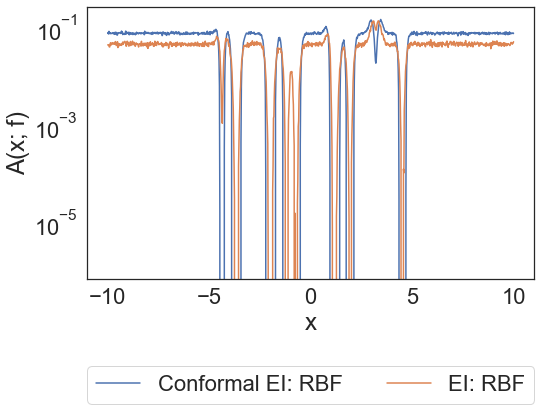

In [141]:
plt.figure(figsize = (8, 5))
plt.plot(test_x.squeeze(), conformal_ei(m1).detach(), label = "Conformal EI: RBF")
# plt.plot(test_x.squeeze(), conformal_ei(m3).detach(), label = "Conformal EI: RQ")
plt.plot(test_x.squeeze(), batch_ei.squeeze(), label = "EI: RBF")
# plt.plot(test_x.squeeze(), batch_ei_rq.squeeze(), label = "EI: RQ")
plt.legend(ncol = 2, loc = "lower center", bbox_to_anchor = (0.5, -0.5))
plt.xlabel("x")
plt.ylabel("A(x; f)")
plt.semilogy()

[]

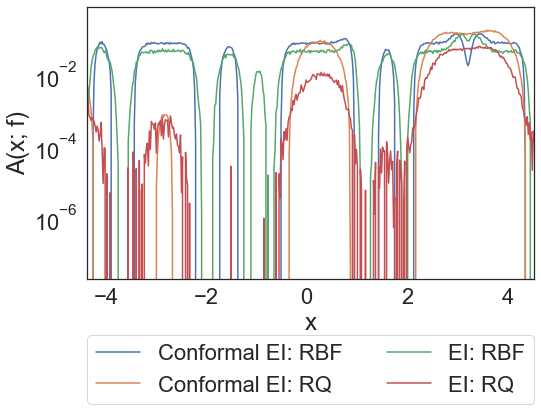

In [142]:
plt.figure(figsize = (8, 5))
plt.plot(test_x.squeeze(), conformal_ei(m1).detach(), label = "Conformal EI: RBF")
plt.plot(test_x.squeeze(), conformal_ei(m3).detach(), label = "Conformal EI: RQ")
plt.plot(test_x.squeeze(), batch_ei.squeeze(), label = "EI: RBF")
plt.plot(test_x.squeeze(), batch_ei_rq.squeeze(), label = "EI: RQ")
plt.legend(ncol = 2, loc = "lower center", bbox_to_anchor = (0.5, -0.5))
plt.xlabel("x")
plt.ylabel("A(x; f)")
plt.xlim((train_x.min(), train_x.max()))
plt.semilogy()

In [143]:
    samples = 4096
    scores = get_scores(m3)
    # calibration set is of size 50
    # qhats = torch.quantile(scores, torch.ceil(51 * (1 - alphas)).squeeze() / 50)
    alpha = 0.05
    qhat = torch.quantile(scores, torch.ceil((nv + 1) * (1 - alpha) * torch.ones(1)) / nv)
    
    m_post = m1.posterior(test_x, observation_noise=True)
    scaling = m_post.variance.squeeze(-1).unsqueeze(0).sqrt() * qhat.unsqueeze(-1).unsqueeze(-1)
    # conformal_samples = torch.rand(scaling.shape[1:]) * 2 * scaling + m_post.mean.squeeze(-1).unsqueeze(0) - scaling

In [144]:
# lower = torch.quantile(conformal_samples, 0.025, dim=-3).squeeze().detach()
# upper = torch.quantile(conformal_samples, 0.975, dim=-3).squeeze().detach()
scaling = scaling.detach()
lower = m_post.mean.view(-1).detach() - scaling.view(-1)
upper = m_post.mean.view(-1).detach() + scaling.view(-1)

In [145]:
gp_lower = (m_post.mean - 2 * m_post.variance.sqrt()).squeeze().detach()
gp_upper = (m_post.mean + 2 * m_post.variance.sqrt()).squeeze().detach()


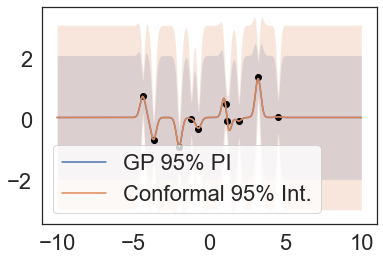

In [146]:
plt.plot(test_x.squeeze(), m_post.mean.detach().squeeze(), label = "GP 95% PI")
plt.fill_between(test_x.squeeze(), gp_lower, gp_upper, alpha = 0.2)

plt.plot(test_x.squeeze(), m_post.mean.squeeze(-1).detach(), label = "Conformal 95% Int.")
plt.fill_between(test_x.squeeze(), lower, upper, alpha = 0.2)

plt.scatter(train_x, train_y, color = "black")
plt.legend()

In [144]:
(conformal_samples - train_y.max()).clamp_min(0).sum()

tensor(0., grad_fn=<SumBackward0>)

In [145]:
mean = conformal_samples.mean(dim=0)
ucb_samples = mean + 0.01 * (conformal_samples - mean).abs()
ucb_output = ucb_samples.max(dim=-1)[0].mean(dim=0)

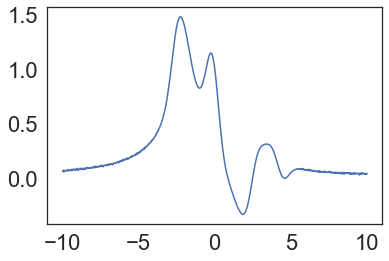

In [146]:
plt.plot(test_x.squeeze(), ucb_output.detach())

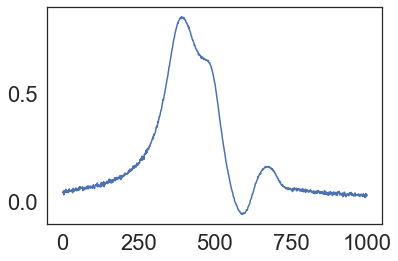

In [123]:
plt.plot(mean.detach())